# <div style="text-align: center"><font color='#dc2624' face='微软雅黑'>Python 进阶之数据分析</font></div>
## <div style="text-align: center"><font color='#dc2624' face='微软雅黑'>案例 6 - 蒙特卡洛定价百慕大期权</font></div>

## <font color='#dc2624' face='微软雅黑'>目录</font><a name='toc'></a>
### 1. [**<font color='#dc2624' face='微软雅黑'>蒙特卡洛 101</font>**](#1)
1. [<font color='#2b4750' face='微软雅黑'>大数定理</font>](#1.1)
2. [<font color='#2b4750' face='微软雅黑'>中央极限定理</font>](#1.2)
3. [<font color='#2b4750' face='微软雅黑'>方差缩减</font>](#1.3)
4. [<font color='#2b4750' face='微软雅黑'>采样 vs 模拟</font>](#1.4)

### 2. [**<font color='#dc2624' face='微软雅黑'>欧式期权</font>**](#2)
1. [<font color='#2b4750' face='微软雅黑'>产品介绍</font>](#2.1)
2. [<font color='#2b4750' face='微软雅黑'>标的采样</font>](#2.2)
3. [<font color='#2b4750' face='微软雅黑'>期权定价</font>](#2.3)

### 3. [**<font color='#dc2624' face='微软雅黑'>美式期权</font>**](#3)
1. [<font color='#2b4750' face='微软雅黑'>产品介绍</font>](#3.1)
2. [<font color='#2b4750' face='微软雅黑'>路径模拟</font>](#3.2)
3. [<font color='#2b4750' face='微软雅黑'>期权定价</font>](#3.3)

### 4. [**<font color='#dc2624' face='微软雅黑'>百慕大期权</font>**](#4)
1. [<font color='#2b4750' face='微软雅黑'>产品介绍</font>](#4.1)
2. [<font color='#2b4750' face='微软雅黑'>期权定价</font>](#4.2)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from numpy import polyfit, polyval
from numpy.polynomial.laguerre import lagfit, lagval

from scipy.stats import norm

In [ ]:
np.random.seed(1031)
mpl.rcParams['font.sans-serif']=['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus']=False

In [ ]:
import cufflinks as cf
cf.go_offline()

# <font color='#dc2624' face='微软雅黑'>1. 蒙特卡洛 101</font><a name='1'></a>
[<font color='black' face='微软雅黑'>回到目录</font>](#toc)

蒙特卡洛模拟 (Monte Carlo Method) 在量化金融中被广泛使用，通过模拟会影响一个金融产品或一个组合价值的不确定来源，然后确定其价值在可能结果范围内的分布，来对产品或组合进行价值评估和分析。

在金融产品定价上，蒙特卡洛主要根据**大数定理** (Law of Large Number) 以及**中央极限定理** (central limit theorem) 为理论根基，将期望表达式转换成算数平均表达式，然后模拟在每条路径上产品支付函数，将其累加再求平均值。

<br>
<font color='blue'>
\begin{equation}
\mathbb{E}[X] = \frac{1}{n}\sum_{i=1}^{n}X_{i}
\end{equation}
</font>

蒙特卡洛模拟非常简单，因为：

- 通常资产在到期日会遵循某个概率分布 (而这些概率分布函数在几乎所有语言中都可以直接运用)
- 通常支付函数而资产的关系简单直接，在到期日模拟出资产价格直接带入支付函数得到产品在到期日的价值

### <font color='#2b4750' face='微软雅黑'>1.1 大数定理</font><a name='1.1'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#1)

假设 $Y_1$, $Y_2$, ... $Y_n$ 是服从独立同分布 (independent identically distributed, i.i.d) 的随机变量。计算样本均值 (sample mean) $\bar{Y}(n)=\frac{1}{n} \sum_{i=1}^{n} Y_{i}$，当 $n$ 越大时，样本均值 $\bar{Y}(n)$ 越趋近总体均值 (population mean) $\mu$。

<br>
<font color='blue'>
\begin{equation}
\lim _{n \rightarrow \infty} \overbrace{Y(n)}^{\text{样本均值}}=\lim _{n \rightarrow \infty} \frac{1}{n} \sum_{i=1}^{n} Y_{i}=\overbrace{\mu}^{\text{总体均值}}
\end{equation}
</font>

考虑一个金融产品在到期日 $T$ 的支付函数是 $V(T) = g(T)$，根据无套利原则得到该产品在 $t$ 时的价值 <font color='blue'>$V(t)=e^{-r(T-t)} \times \mathbb{E}_{t}^{\mathbb{Q}}[g(T)]$</font>，套用上面的**大数定理**，将“总体均值”的 $V(t)$ 用“样本均值”的 $\bar{V}(t)$ 来近似，得到

<br>
<font color='blue'>
\begin{equation}
V(t) \approx \bar{V}(t) = e^{-r(T-t)} \times \frac{1}{n} \sum_{i=1}^{n} g_{i}
\end{equation}
</font>

整个过程分为三步：

1. 在风险中性测度下 $\mathbb{Q}$ 生成 $n$ 个样本 $g_1$, $g_2$, ... $g_n$  
2. 计算它们的均值
3. 乘以折现因子 $e^{-r(T-t)}$ 得到现值

### <font color='#2b4750' face='微软雅黑'>1.2 中央极限定理</font><a name='1.2'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#1)

假设 $Y_1$, $Y_2$, ... $Y_n$ 是服从独立同分布 (independent identically distributed, i.i.d) 的随机变量，其总体均值和标准差分别为 $\mu$ 和 $\sigma$，当 $n$ 趋向无穷时，

<br>
<font color='blue'>
\begin{equation}
\frac{\overbrace{Y(n)}^{\text{样本均值}} - \overbrace{\mu}^{\text{总体均值}}}{\frac{\sigma}{n}} \sim \mathcal{N}(0,1)
\end{equation}
</font>

定义样本方差 $s(n)$

<br>
<font color='blue'>
\begin{equation}
s^{2}(n)=\frac{1}{n-1} \sum_{i=1}^{n}\left[Y_{i}-\bar{Y}(n)\right]^{2}=\frac{n}{n-1} \sigma^{2}
\end{equation}
</font>

那么

<br>
<font color='blue'>
\begin{equation}
\frac{\overbrace{Y(n)}^{\text{样本均值}} - \overbrace{\mu}^{\text{总体均值}}}{\frac{s(n)}{n}} \sim \mathcal{N}(0,1)
\end{equation}
</font>

其中 $\frac{s(n)}{\sqrt{n}}$ 称为标准误差 (standard error)。

当样本大小 $n$ 足够大时，**<font color='red'>样本均值 (计算的)</font>** 和**<font color='green'>总体均值 (真实的)</font>** 之差再除以标准误差服从标准正态分布，因此给定置信水平 (confidence level) $1-\alpha$，可推出**<font color='green'>真实值</font>**所处的置信区间 (confidence interval)。

<br>
<font color='blue'>
\begin{equation}
V(t) \in\left[\bar{V}(t)-z_{\frac{\alpha}{2}} \cdot \frac{s(n)}{\sqrt{n}}, \quad \bar{V}(t)+z_{\frac{\alpha}{2}} \cdot \frac{s(n)}{\sqrt{n}}\right]
\end{equation}
</font>

其中 $z_{\frac{\alpha}{2}}$ 是标准正态分布的分位数 (quantile)。

### <font color='#2b4750' face='微软雅黑'>1.3 方差缩减</font><a name='1.3'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#1)

在上面置信区间的公式中，最重要的一项就是标准误差

<br>
<font color='blue'>
\begin{equation}
\frac{\overbrace{s(n)}^{\text{标准误差} \downarrow}}{\sqrt{n}}
    =\frac{n-1}{n} \frac{\overbrace{\sigma}^{\text{方差} \downarrow}}{\underbrace{\sqrt{n}}_{\text{样本大小}\uparrow}}
\end{equation}
</font>
    
显然，当标准误差越大，那么置信区间越宽，蒙特卡洛计算结果也就越不精确。因此减小标准误差是整套蒙特卡洛方法论中最重要的技巧，有两个方法：

1. **蛮力法**：增大样本数 $n$，但由于 $n$ 带着根号，因此效率不高
2. **聪明法**：直接减小方差 $\sigma$

为了理解为何**蛮力法**的效率不高，假设样本大小为 $n$ 时，计算结果具有一定的精度，现在希望将精度提高一个数量级。 例如现在期权价格的置信区间为 (**<font color='red'>1.2</font>**38，**<font color='red'>1.2</font>**85)，这时期权价格精确到小数点后第一位。 为了获得小数点后第二位的精度，那么 $\sqrt{n}$ 要增大 10 倍，这意味着 $n$ 要增大 100 倍。因此，蛮力法会导致大量的计算开销。


第二种方法可以理解是用更聪明的采样得到新的一组 $Y_{\text{new}}$，使得方差变小而均值不变。

<br>
<font color='blue'>
\begin{equation}
\mathbb{V}(Y_{\text{new}}) < \mathbb{V}(Y)
\end{equation}
\begin{equation}
\mathbb{E}(Y_{\text{new}}) = \mathbb{E}(Y)
\end{equation}
</font>

样本 $Y_{\text{new}}$ 或 $Y$ 可想成期权的支付值，期权价格就是 $\mathbb{E}(Y_{\text{new}})$ 或 $\mathbb{E}(Y)$ 的均值，如果用一组更聪明的采样使得方差减小但均值变了，那不是适得其反么？

方差缩减核心就是用聪明的采样，减低方差，保住均值。方法有很多，由易到难，由无脑生成到精心设计，如下图所示：

<img src="Variance Reduction.PNG" style="width:800px;height:360px;">

<br>
五种方差缩减方法简述如下:

- **对立变量** (Antithetic Variate)：几乎什么时候都能用，万金油


- **控制变量** (Control Variate)：知道随机变量 $X$ 的期望，而 $Y$ 和 $X$ 正相关，比如用几何平均亚式期权当控制变量 $X$，来对算术平均亚式期权 $Y$ 的价格


- **条件抽样** (Conditioning Sampling)：$\mathbf{V}[Y] > \mathbf{V}[\mathbf{E}[Y|Z]]$，假设 $Y$ 是服从学生分布，那么 $Y = \frac{X}{\sqrt{Z}}$，其中 $X$ 是正态分布而 $Z$ 是卡方分布，那么给定一个特定 $Z = z$ 值，$Y$ 就是正态分布了。因此 $Z$ 从卡方分布用采样，$Y|Z$ 就可以从正态分布中采样了。


- **分层抽样** (Stratified Sampling)：$\mathbf{V}[Y] > \mathbf{E}[\mathbf{V}[Y|Z]]$，给定一个特征 $Z = z$ 值后在 $Y$ 上采样，叫做层 (strata)。


- **重要性抽样** (Importance Sampling)：运用变换概率测度的方法，比如深度价外看涨期权 ($K$ 远大于 $S$) 的模拟的很多路径都得到 0 的支付，这样模拟效果比较低，因此可能平移 $S$ 的漂移项而改变 $S$ 的分布。

### <font color='#2b4750' face='微软雅黑'>1.4 采样 vs 模拟</font><a name='1.4'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#1)

采样 (sampling) 和模拟 (simulation) 经常被混淆：

- **采样**：给定一个时点，在空间维度 (spatial dimension) 生成一维随机变量

- **模拟**：给定多个时点，即在时间维度 (temporal dimension) 也在空间维度上生成两维随机变量。

采样适用于欧式期权定价，模拟适用于美式、百慕大、亚式和障碍期权定价。

<img src="sample vs simulate.png" style="width:700px;height:380px;">


蒙特卡洛方法可以处理三种问题：

1. 随机微分方程 (Stochastic Differential Equation, SDE) 有解的，产品支付函数是欧式的：只用采样一个时点 (多条路径)，只有采样误差，没有离散误差。

    应用：BS 模型欧式期权
<br>

2. SDE 有解的，产品支付函数和路径有关：需要采样多个时点 (多条路径)，只有采样误差，没有离散误差。

    应用：BS 模型美式、障碍期权
<br>

3. SDE 没有解：需要采样多个时点 (多条路径)，即有采样误差，又有离散误差。

    应用：Heston 模型欧式，美式、障碍期权
    
<img src="sample and discretization.png" style="width:1000px;height:450px;">

# <font color='#dc2624' face='微软雅黑'>2. 欧式期权</font><a name='2'></a>
[<font color='black' face='微软雅黑'>回到目录</font>](#toc)
### <font color='#2b4750' face='微软雅黑'>2.1 产品介绍</font><a name='2.1'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#2)

定义：期权买方和卖方进入**欧式期权** (European option) 合约的将同意以下内容：

- 期权买方付出期权金 (premium) 便有权利 (right)去行使，而卖方收取期权金后则有义务 (obligation) 履行买方行使权利的义务
- 看涨期权：买方有权利在到期日以 $K$ 买入标的，获得 $(S - K)$
- 看跌期权：买方有权利在到期日以 $K$ 卖出标的，获得 $(K - S)$
- 而卖方一旦被行使期权时，则有义务支付该差额给买方

其中 $K$ 是执行价格 (strike price)。

### <font color='#2b4750' face='微软雅黑'>2.2 标的采样</font><a name='2.2'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#2)

在**布莱克斯科尔斯** (Black-Scholes, BS) 模型下，原生资产的随机微分方程 (Stochastic Differential Equation, SDE) 如下：

<br>
<font color='blue'>
\begin{equation}
\frac{dS(t)}{S(t)} = (r-q)dt+\sigma dW(t)
\end{equation}
</font>
    
其中

- $S(t)$ = 原生资产在时点 $t$ 的值
- $r$ = 常数型本币瞬时利率 (domestic instantaneous rate)
- $q$ = 常数型
    - **股票类**：红利率 (dividend yield)
    - **商品类**：净便利收益率 (net convenience yield)
    - **外汇率**：外币瞬时利率 (foreign instantaneous rate)
- $\sigma$ = 常数型瞬时波动率
- $W(t)$ = 布朗运动

根据伊藤定理，解出标的在 $T$ 时的值 $S(T)$

<br>
<font color='blue'>
\begin{equation}
S(T) = S(0) \cdot \exp\left( \left(r-q-\frac{1}{2}\sigma^2 \right)T +\sigma \sqrt{T}\cdot z \right) 
\end{equation}
</font>

其中 <font color='blue'>$z \sim \mathcal{N}(0,1)$</font>，是标准正态分布随机变量。

In [ ]:
(S0, r, q, T, sigma) = (1, 0.02, 0, 1, 0.2)
(Nsim, Nt) = (10, 2)

t = np.linspace(0,T,Nt)
dt = np.diff(t)

z = np.random.randn(Nsim, Nt-1)
A = (r-q-0.5*(sigma)**2)*dt + sigma*(z*np.sqrt(dt))

lnS0 = np.tile(np.log(S0),(Nsim,1))
lnS = lnS0 + np.cumsum(A, axis=1)
lnS = np.hstack( (lnS0, lnS) )
S = np.exp(lnS)

In [ ]:
label = [ x + ' ' + str(y) for x, y in zip(['path']*Nsim, np.arange(1,Nsim+1)) ]
df = pd.DataFrame(S.T, index=t, columns=label)
df

,path 1,path 2,path 3,path 4,path 5,path 6,path 7,path 8,path 9,path 10
0.0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000
1.0,0.950326,0.803143,1.205945,1.089881,1.23086,0.773066,1.675763,0.788426,0.741816,1.01691


In [ ]:
df.iplot( xTitle='t', yTitle='S', mode='lines+markers', size=5, title='到期日时的价格采样', theme='ggplot' )

对于随机变量 $S(T)$，可以计算出它的均值，在定价欧式期权之前，可以比较样本均值和真实均值 (在 Black-Scholes 模型下有解析解)，确保采样质量。

<br>
<font color='blue'>
\begin{equation}
\mathbf{E}[S(T)] = S(0)\cdot e^{rT} 
\end{equation}
</font>

计算出来结果为

In [ ]:
S0*np.exp(r*T)

1.0202013400267558

In [ ]:
def underlying( S0, r, q, T, sigma, Nsim, Nt ):
    
    t = np.linspace(0,T,Nt)
    dt = np.diff(t)
    z = np.random.randn(Nsim, Nt-1)
    A = (r-q-0.5*(sigma)**2)*dt + sigma*(z*np.sqrt(dt))

    lnS0 = np.tile(np.log(S0),(Nsim,1))
    lnS = lnS0 + np.cumsum(A, axis=1)
    lnS = np.hstack( (lnS0, lnS) )
    S = np.exp(lnS)
    return S

In [ ]:
Nsim = [1, 10, 100, 1000, 10000, 100000]
Ntrial = 100
results = np.zeros((Ntrial,len(Nsim)))

for i in np.arange(Ntrial):
    for j, N in enumerate(Nsim):
        S = underlying( S0, r, q, T, sigma, N, Nt )
        results[i,j] = np.mean(S[:,-1])
#results

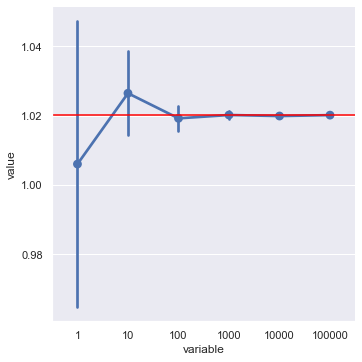

In [ ]:
df = pd.DataFrame( results, columns=Nsim )
sns.set_theme(style="darkgrid")
g = sns.catplot(x="variable", y="value", kind='point', data=df.melt());

true_mean = S0*np.exp(r*T)
plt.axhline( y=true_mean, color='red');

### <font color='#2b4750' face='微软雅黑'>2.3 期权定价</font><a name='2.3'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#2)

定价一个欧式看跌期权，参数如下：

In [ ]:
(S0, K, r, q, T, sigma, omega) = (1, 1.1, 0.02, 0, 1, 0.2, -1)
(Nsim, Nt) = (10000, 2)

首先采样到期日标的价格 $S(T)$

In [ ]:
Smat = underlying( S0, r, q, T, sigma, Nsim, Nt )
S = Smat[:,-1]

在到期日将 $S(T)$ 带入期权支付函数 $\text{max}(K - S(T),0)$，计算均值得到期权价格：

In [ ]:
V_MC = np.exp(-r*T) * np.mean( np.maximum(omega*(S-K), 0) )
V_MC

0.12782135700532118

拿蒙卡数值解比较解析解，发现结果非常接近。

In [ ]:
def BlackScholes( S0=100, K=100, r=0.01, q=0.01, T=1, sigma=0.2, omega=1 ):
    discount = np.exp(-r*T)
    forward = S0*np.exp((r-q)*T)
    moneyness = np.log(forward/K)
    vol_sqrt_T = sigma*np.sqrt(T)
    
    d1 = moneyness / vol_sqrt_T + 0.5*vol_sqrt_T
    d2 = d1 - vol_sqrt_T
    
    V = omega * discount * (forward*norm.cdf(omega*d1) - K*norm.cdf(omega*d2))
    return V

In [ ]:
V_CF = BlackScholes(S0, K, r, q, T, sigma, omega)
V_CF

0.12765721020973578

使用对立变量 (Antithetic Variate) 来缩减方差。

In [ ]:
def underlying( S0, r, q, T, sigma, Nsim, Nt, antithetic=False ):
    
    t = np.linspace(0,T,Nt)
    dt = np.diff(t)
    
    if antithetic:
        z1 = np.random.randn(int(Nsim/2), Nt-1)
        z = np.vstack([z1, -z1])
    else:
        z = np.random.randn(Nsim, Nt-1)
    
    A = (r-q-0.5*(sigma)**2)*dt + sigma*(z*np.sqrt(dt))

    lnS0 = np.tile(np.log(S0),(Nsim,1))
    lnS = lnS0 + np.cumsum(A, axis=1)
    lnS = np.hstack( (lnS0, lnS) )
    S = np.exp(lnS)
    return S

In [ ]:
Smat = underlying( S0, r, q, T, sigma, Nsim, Nt )
V_MC = np.exp(-r*T) * np.mean( np.maximum(omega*(Smat[:,-1]-K), 0) )
V_MC

0.12732641253031846

In [ ]:
Smat = underlying( S0, r, q, T, sigma, Nsim, Nt, antithetic=True )
V_AV = np.exp(-r*T) * np.mean( np.maximum(omega*(Smat[:,-1]-K), 0) )
V_AV

0.12777726135552336

# <font color='#dc2624' face='微软雅黑'>3. 美式期权</font><a name='3'></a>
[<font color='black' face='微软雅黑'>回到目录</font>](#toc)
### <font color='#2b4750' face='微软雅黑'>3.1 产品介绍</font><a name='3.1'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#3)

定义：定义：期权买方和卖方进入**美式期权** (American option) 合约的将同意以下内容：

- 期权买方付出期权金 (premium) 便有权利 (right)去行使，而卖方收取期权金后则有义务 (obligation) 履行买方行使权利的义务
- 看涨期权：买方有权利**<font color='red'>在到期日之前任意时间</font>**以 $K$ 买入标的，获得 $(S - K)$
- 看跌期权：买方有权利**<font color='red'>在到期日之前任意时间</font>**以 $K$ 卖出标的，获得 $(K - S)$
- 而卖方一旦被行使期权时，则有义务支付该差额给买方

其中 $K$ 是执行价格 (strike price)。

### <font color='#2b4750' face='微软雅黑'>3.2 路径模拟</font><a name='3.2'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#3)

由于美式期权的买方在到期日之前任意时间都可以行使权利，那么在定价时需要多个时间点上的标的价格。

给定一组期限 <font color='blue'>$0=t_0<t_1<\cdots<t_n<\cdots<t_N=T$</font>，其中 <font color='blue'>$\Delta t=\frac{T}{N}$</font>，用 <font color='blue'>$t_{n}$</font> 和 <font color='blue'>$t_{n+1}$</font> 替代上节公式中的 <font color='blue'>$0$</font> 和 <font color='blue'>$T$</font> 得到

<br>
<font color='blue'>
\begin{equation}
S(t_{n+1}) = S(t_{n}) \cdot \exp\left( \left(r-q-\frac{1}{2}\sigma^2 \right)\Delta t +\sigma \sqrt{\Delta t}\cdot z \right) 
\end{equation}
</font>

为了可视化效果，只模拟 10 条不同路径的 <font color='blue'>$S(T)$</font>，按照以下公式，先模拟 <font color='blue'>$\ln S(T)$</font>，再用 <font color='blue'>$\exp(\ln S(T))$</font> 返回 <font color='blue'>$S(T)$</font>。

<br>
<font color='blue'>
\begin{equation}
\ln S(t_{n+1}) = \ln S(t_{n}) + \left(r-q-\frac{1}{2}\sigma^2 \right)\Delta t +\sigma \sqrt{\Delta t}\cdot z
\end{equation}
</font>

In [ ]:
(S0, r, q, T, sigma) = (1, 0.02, 0, 1, 0.2)
(Nsim, Nt) = (10, 100)
S = underlying( S0, r, q, T, sigma, Nsim, Nt )

In [ ]:
t = np.linspace(0,T,Nt)
label = [ x + ' ' + str(y) for x, y in zip(['path']*Nsim, np.arange(1,Nsim+1)) ]
df = pd.DataFrame(S.T, index=t, columns=label)
df

,path 1,path 2,path 3,path 4,path 5,path 6,path 7,path 8,path 9,path 10
0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.010101,0.991324,1.002607,0.981853,0.988715,1.002049,1.013049,0.985246,0.956521,1.005149,0.996089
0.020202,1.009827,0.978105,0.992834,1.000892,0.994189,1.025581,1.039250,0.961948,1.023016,1.006717
0.030303,1.010072,0.974834,1.033206,0.990844,1.017768,1.042473,1.052578,0.951054,1.061005,1.032759
0.040404,1.002931,0.981445,1.049170,0.981363,1.025709,1.017816,1.041569,0.948680,1.084442,1.004052
...,...,...,...,...,...,...,...,...,...,...
0.959596,1.005388,0.787418,1.236006,1.385918,0.910812,1.151410,1.108869,0.974586,1.178282,0.938577
0.969697,1.020416,0.806541,1.229550,1.352031,0.897784,1.189192,1.079602,0.980024,1.198456,0.956941
0.979798,0.993938,0.831657,1.250107,1.346607,0.897019,1.185586,1.050345,0.985673,1.185275,0.966256
0.989899,0.947592,0.840964,1.210702,1.299765,0.896163,1.183743,1.038821,1.019851,1.196031,0.955269


In [ ]:
df.iplot( xTitle='t', yTitle='S', mode='lines+markers', size=5, title='价格模拟', theme='ggplot' )

### <font color='#2b4750' face='微软雅黑'>3.3 期权定价</font><a name='3.3'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#3)

由于美式期权允许期权买方在到期日之前的任何时刻执行期权，因此没有解析解 (有 BAW 和 JZ 的近似解析解，但都有局限性)，因此对美式期权的定价通常只能采用数值解的方法，比如偏微分方程有限差分方法和蒙特卡洛方法。

然而，由于蒙特卡洛采用的是正向求解的方法，我们无法计算在每个时刻继续持有期权的期望收益，从而无法比较在该时刻**<font color='red'>立即执行期权的收益 (exercise value)</font>** 与**<font color='green'>继续持有期权的期望收益 (holding value)</font>**，进而无法决定是立即执行还是继续持有期权。因此一直以来人们还认为蒙特卡洛方法只适合定价欧式期权，而不适合为定价美式期权。直到 2000 年，UCLA 的两位教授 Longstaff 和 Schwartsz 在论文中

https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf

提出的最小二乘蒙特卡洛 (Least Square Monte Carlo, LSMC) 方法，它已成为目前使用定价美式期权、定价包含提前执行权利产品的标准方法。

下面以定价一个一年到期美式看跌期权 ($S0=1, K=1.1, r=6\%$) 为例，用 11 张图来“可视化” LSMC 方法的精髓。

<img src="LSMC1.PNG" style="width:900px;height:409px;">

<img src="LSMC2.PNG" style="width:900px;height:366px;">

<img src="LSMC3.PNG" style="width:900px;height:624px;">

<img src="LSMC4.PNG" style="width:900px;height:601px;">

<img src="LSMC5.PNG" style="width:900px;height:645px;">

<img src="LSMC6.PNG" style="width:900px;height:389px;">

<img src="LSMC7.PNG" style="width:900px;height:625px;">

<img src="LSMC8.PNG" style="width:900px;height:625px;">

<img src="LSMC9.PNG" style="width:900px;height:609px;">

<img src="LSMC10.PNG" style="width:900px;height:389px;">

<img src="LSMC11.PNG" style="width:1000px;height:450px;">

接下来用代码来实现上图过程，特别是用回归方法来计算期权在任意时点的持有价值。

设定标的的“模拟”价格。

In [ ]:
S = np.array( [[1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
               [1.09, 1.16, 1.22, 0.93, 1.11, 0.76, 0.92, 0.88],
               [1.08, 1.26, 1.07, 0.97, 1.56, 0.77, 0.84, 1.22],
               [1.34, 1.54, 1.03, 0.92, 1.52, 0.90, 1.01, 1.34]] )
S

array([[1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [1.09, 1.16, 1.22, 0.93, 1.11, 0.76, 0.92, 0.88],
       [1.08, 1.26, 1.07, 0.97, 1.56, 0.77, 0.84, 1.22],
       [1.34, 1.54, 1.03, 0.92, 1.52, 0.9 , 1.01, 1.34]])

设定期权的参数。

In [ ]:
(S0, r, K, T, omega) = (1, 0.06, 1.1, 3, -1)
(Nt, Nsim) = (4, S.shape[1])

计算每个时点间隔的折现因子。

In [ ]:
DF = np.exp(-r*T/(N-1))
DF

0.9417645335842487

In [ ]:
CF = np.maximum(omega*(S[-1,:]-K), 0)
path = np.arange(Nsim)

for i in np.arange(N-2,0,-1):
    # discount cashflow from T_{i+1} to T_{i}
    CF = CF * DF
    
    # find the index of path where option is ITM
    ITM_bool = omega*(S[i]-K) > 0
    
    # slice the underlying and discounted CF under ITM path
    X = S[i, ITM_bool]
    Y = CF[ITM_bool]
        
    # regress Y against X with polynomial function
    coef = polyfit(X, Y, 2)
    
    print( f'索引 {i} 回归函数：E[Y|X] = {coef[0]:.3f}X^2 + {coef[1]:.3f}X + {coef[2]:.3f}\n')
    
    # compute the holdind value and exercise value
    HV = polyval(coef, X)
    EV = np.maximum(omega*(X-K), 0)
    
    # find the exercise path and update the cashflow
    EP_bool = (EV > HV)
    EP = path[ITM_bool][EP_bool]
    
    CF[EP] = EV[EP_bool]
    
V = np.maximum( omega*(S0 - K), np.mean(CF*DF) )
V

索引 2 回归函数：E[Y|X] = -1.814X^2 + 2.983X + -1.070

索引 1 回归函数：E[Y|X] = 1.356X^2 + -3.335X + 2.038



0.11443433004505696

上述例子虽然不现实，但是可以帮助我们弄清楚 LSMC 所有核心技巧，而只需上述代码不需要做任何修改就可以定价美式期权，只要提供“合理”的标的模拟价格。为了方便使用，将上述代码整合成一个函数：

In [ ]:
def LSMC(S, K, r, T, N, Nsim, omega, verbose=False):
    DF = np.exp(-r*T/(N-1))
    CF = np.maximum(omega*(S[-1,:]-K), 0)
    path = np.arange(Nsim)

    for i in np.arange(N-2,0,-1):
        # discount cashflow from T_{i+1} to T_{i}
        CF = CF * DF

        # find the index of path where option is ITM
        ITM_bool = omega*(S[i]-K) > 0

        # slice the underlying and discounted CF under ITM path
        X = S[i, ITM_bool]
        Y = CF[ITM_bool]

        # regress Y against X with polynomial function
        coef = polyfit(X, Y, 2)

        if verbose:
            print( f'索引 {i} 回归函数：E[Y|X] = {coef[0]:.3f}X^2 + {coef[1]:.3f}X + {coef[2]:.3f}\n')

        # compute the holdind value and exercise value
        HV = polyval(coef, X)
        EV = np.maximum(omega*(X-K), 0)

        # find the exercise path and update the cashflow
        EP_bool = (EV > HV)
        EP = path[ITM_bool][EP_bool]

        CF[EP] = EV[EP_bool]

    V = np.maximum( omega*(S0 - K), np.mean(CF*DF) )
    return V

还是用简单例子测试一下：

In [ ]:
LSMC(S, K, r, T, Nt, M, omega, verbose=True)

索引 2 回归函数：E[Y|X] = -1.814X^2 + 2.983X + -1.070

索引 1 回归函数：E[Y|X] = 1.356X^2 + -3.335X + 2.038



0.11443433004505696

再看一个真实例子，按照论文中的设置：

<img src="paper setting.PNG" style="width:700px;height:200px;">

使用 50000 个对立变量，因此总共 100000 条路径；每一年分成 50 个间隔，因此 51 个时点。

In [ ]:
(S0, K, r, q, sigma, T, omega) = (36, 40, 0.06, 0, 0.2, 1, -1)
(Nsim, Nt) = (100000, 51)
Smat = underlying( S0, r, q, T, sigma, Nsim, Nt, antithetic=True )

In [ ]:
LSMC(Smat.T, K, r, T, Nt, Nsim, omega, verbose=True)

索引 49 回归函数：E[Y|X] = 0.002X^2 + -1.111X + 41.574

索引 48 回归函数：E[Y|X] = 0.003X^2 + -1.188X + 42.717

索引 47 回归函数：E[Y|X] = 0.004X^2 + -1.222X + 43.181

索引 46 回归函数：E[Y|X] = 0.005X^2 + -1.287X + 44.146

索引 45 回归函数：E[Y|X] = 0.006X^2 + -1.334X + 44.834

索引 44 回归函数：E[Y|X] = 0.006X^2 + -1.382X + 45.527

索引 43 回归函数：E[Y|X] = 0.007X^2 + -1.413X + 45.984

索引 42 回归函数：E[Y|X] = 0.008X^2 + -1.494X + 47.191

索引 41 回归函数：E[Y|X] = 0.008X^2 + -1.470X + 46.775

索引 40 回归函数：E[Y|X] = 0.009X^2 + -1.529X + 47.691

索引 39 回归函数：E[Y|X] = 0.009X^2 + -1.554X + 48.074

索引 38 回归函数：E[Y|X] = 0.010X^2 + -1.583X + 48.452

索引 37 回归函数：E[Y|X] = 0.010X^2 + -1.595X + 48.606

索引 36 回归函数：E[Y|X] = 0.011X^2 + -1.623X + 49.009

索引 35 回归函数：E[Y|X] = 0.011X^2 + -1.667X + 49.700

索引 34 回归函数：E[Y|X] = 0.012X^2 + -1.706X + 50.266

索引 33 回归函数：E[Y|X] = 0.013X^2 + -1.764X + 51.198

索引 32 回归函数：E[Y|X] = 0.013X^2 + -1.773X + 51.320

索引 31 回归函数：E[Y|X] = 0.014X^2 + -1.838X + 52.341

索引 30 回归函数：E[Y|X] = 0.015X^2 + -1.871X + 52.839

索引 29 回归函数：E[Y|X] = 

4.465844915158158

和论文中下表中的结果 4.472 非常接近。

<img src="paper results.PNG" style="width:300px;height:400px;">

# <font color='#dc2624' face='微软雅黑'>4. 百慕大期权</font><a name='4'></a>
[<font color='black' face='微软雅黑'>回到目录</font>](#toc)
### <font color='#2b4750' face='微软雅黑'>4.1 产品介绍</font><a name='4.1'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#4)

百慕大期权 (Bermuda option) 是一种可以在到期日前所规定的一系列时间行权的期权。比如，期权 3 年后到期，但只有在最后一年的每个月才能被执行。由于美式期权是可以在任意时间行权，因此美式期权可看成是一种特殊的百慕大期权。

### <font color='#2b4750' face='微软雅黑'>4.2 期权定价</font><a name='4.3'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#4)

考虑三个百慕大看跌期权，如下表所示：

|属性|股票价格|行权价格|连续利率|连续红利率|波动率|到期年限|
|---|:---:|:---:|:---:|:---:|:---:|:---:|
|值|50|60|3%|1%|40%|1|

不同的是它们分别是 (执行日不包括最后到日期)

- 每半年执行权利，执行日的年限为 [0.5]
- 每三个月年执行权利，执行日的年限为 [0.25,0.5,0.75]
- 每个月年执行权利，执行日的年限为 [1/12,2/12,3/12,4/12,5/12,6/12,7/12,8/12,7/12,9/12,11/12]

In [ ]:
(S0, K, r, q, sigma, T, omega) = (50, 60, 0.03, 0.01, 0.4, 1, -1)
(Nsim, Nt) = (100000, 49)
Smat = underlying( S0, r, q, T, sigma, Nsim, Nt, antithetic=True )

### <font color='black' face='微软雅黑'>欧式期权</font>

In [ ]:
V_euro = np.exp(-r*T) * np.mean( np.maximum(omega*(Smat[:,-1]-K), 0) )
V_euro

13.580178331597173

### <font color='black' face='微软雅黑'>美式期权</font>

In [ ]:
V_amer = LSMC(Smat.T, K, r, T, Nt, Nsim, omega)
V_amer

13.796319639496199

### <font color='black' face='微软雅黑'>百慕大期权</font>

In [ ]:
T_vec = np.linspace(0,T,Nt)
T_vec

array([0.        , 0.02083333, 0.04166667, 0.0625    , 0.08333333,
       0.10416667, 0.125     , 0.14583333, 0.16666667, 0.1875    ,
       0.20833333, 0.22916667, 0.25      , 0.27083333, 0.29166667,
       0.3125    , 0.33333333, 0.35416667, 0.375     , 0.39583333,
       0.41666667, 0.4375    , 0.45833333, 0.47916667, 0.5       ,
       0.52083333, 0.54166667, 0.5625    , 0.58333333, 0.60416667,
       0.625     , 0.64583333, 0.66666667, 0.6875    , 0.70833333,
       0.72916667, 0.75      , 0.77083333, 0.79166667, 0.8125    ,
       0.83333333, 0.85416667, 0.875     , 0.89583333, 0.91666667,
       0.9375    , 0.95833333, 0.97916667, 1.        ])

In [ ]:
T_ex1 = np.array([0, 0.5, T])
idx1 = np.searchsorted(T_vec, T_ex1)
idx1

array([ 0, 24, 48], dtype=int64)

In [ ]:
S = Smat[:,idx1].T
V_berm1 = LSMC(S, K, r, T, S.shape[0], Nsim, omega)
V_berm1

13.725546894302255

In [ ]:
T_ex2 = np.array([0, 0.25,0.5,0.75, T])
idx2 = np.searchsorted(T_vec, T_ex2)
idx2

array([ 0, 12, 24, 36, 48], dtype=int64)

In [ ]:
S = Smat[:,idx2].T
V_berm2 = LSMC(S, K, r, T, S.shape[0], Nsim, omega)
V_berm2

13.788613445105595

In [ ]:
T_ex3 = np.arange(13)/12
idx3 = np.searchsorted(T_vec, T_ex3)
idx3

array([ 0,  4,  8, 12, 16, 21, 24, 29, 32, 36, 41, 44, 48], dtype=int64)

In [ ]:
S = Smat[:,idx3].T
V_berm3 = LSMC(S, K, r, T, S.shape[0], Nsim, omega)
V_berm3

13.802713363873234

In [ ]:
d = {'欧式':V_euro, '百慕大 (按半年执行)':V_berm1, '百慕大 (按季度执行)':V_berm2, '百慕大 (按月执行)':V_berm3, '美式':V_amer}
s = pd.Series(d)
s

欧式             13.580178
百慕大 (按半年执行)    13.725547
百慕大 (按季度执行)    13.788613
百慕大 (按月执行)     13.802713
美式             13.796320
dtype: float64

In [ ]:
s.iplot( xTitle='种类', yTitle='期权价值', mode='lines+markers', size=10, 
         title='最小二乘蒙特卡洛 (二次多项式为基) 期权定价', theme='ggplot' )

从上面结果发现，美式期权价值居然比按月行权的百慕大期权价值小，这不合理，原因可能是回归用的多项式不够好。从论文中得知，用下图 Laguerre 多项式的前三项 $L_0(X)$, $L_1(X)$, $L_2(X)$ 加常数的效果最好。 

<img src="Laguerre Basis.PNG" style="width:600px;height:300px;">

In [ ]:
def LSMC(S, K, r, T, N, Nsim, omega, verbose=False, fit_type='plain'):
    DF = np.exp(-r*T/(N-1))
    CF = np.maximum(omega*(S[-1,:]-K), 0)
    path = np.arange(Nsim)
    fit_type = fit_type.lower()

    for i in np.arange(N-2,0,-1):
        # discount cashflow from T_{i+1} to T_{i}
        CF = CF * DF

        # find the index of path where option is ITM
        ITM_bool = omega*(S[i]-K) > 0

        # slice the underlying and discounted CF under ITM path
        X = S[i, ITM_bool]
        Y = CF[ITM_bool]

        # regress Y against X with polynomial function
        if fit_type =='laguerre':
            coef = lagfit(X, Y, 3)
            # compute holdind value
            HV = lagval(X, coef)
        else:
            coef = polyfit(X, Y, 2)
            # compute holdind value
            HV = polyval(coef, X)
            
        # compute exercise value
        EV = np.maximum(omega*(X-K), 0)

        # find the exercise path and update the cashflow
        EP_bool = (EV > HV)
        EP = path[ITM_bool][EP_bool]

        CF[EP] = EV[EP_bool]
        
        if verbose:
            print( f'索引 {i} 回归函数：E[Y|X] = {coef[0]:.3f}X^2 + {coef[1]:.3f}X + {coef[2]:.3f}\n')
    
    V = np.maximum( omega*(S0 - K), np.mean(CF*DF) )
    return V

In [ ]:
V_amer = LSMC(Smat.T, K, r, T, Nt, Nsim, omega, fit_type='laguerre')
V_amer

13.840660464873938

In [ ]:
S = Smat[:,idx1].T
V_berm1 = LSMC(S, K, r, T, S.shape[0], Nsim, omega, fit_type='laguerre')
V_berm1

13.712431230165866

In [ ]:
S = Smat[:,idx2].T
V_berm2 = LSMC(S, K, r, T, S.shape[0], Nsim, omega, fit_type='laguerre')
V_berm2

13.801750540319805

In [ ]:
S = Smat[:,idx3].T
V_berm3 = LSMC(S, K, r, T, S.shape[0], Nsim, omega, fit_type='laguerre')
V_berm3

13.826012232953891

In [ ]:
d = {'欧式':V_euro, '百慕大 (按半年执行)':V_berm1, '百慕大 (按季度执行)':V_berm2, '百慕大 (按月执行)':V_berm3, '美式':V_amer}
s = pd.Series(d)
s

欧式             13.580178
百慕大 (按半年执行)    13.712431
百慕大 (按季度执行)    13.801751
百慕大 (按月执行)     13.826012
美式             13.840660
dtype: float64

In [ ]:
s.iplot( xTitle='种类', yTitle='期权价值', mode='lines+markers', size=10, 
         title='最小二乘蒙特卡洛 (Laguerre 三项加常数为基) 期权定价', theme='ggplot' )

In [ ]:
dd = {'欧式':[V_euro, 13.5832], 
      '百慕大 (按半年执行)':[V_berm1, 13.7172],
      '百慕大 (按季度执行)':[V_berm2, 13.7753], 
      '百慕大 (按月执行)':[V_berm3, 13.8184],
      '美式':[V_amer,13.8387]}
df = pd.DataFrame(dd, index=['蒙特卡洛','偏微分有限差分'])
df

,欧式,百慕大 (按半年执行),百慕大 (按季度执行),百慕大 (按月执行),美式
蒙特卡洛,13.580178,13.712431,13.801751,13.826012,13.84066
偏微分有限差分,13.583200,13.717200,13.775300,13.818400,13.83870


In [ ]:
df.T.iplot( xTitle='种类', yTitle='期权价值', mode='lines+markers', size=10, 
            title='蒙特卡洛 VS 有限差分期权定价', theme='ggplot' )